# Assignment 3 - Kernel SVM
---
Muhammed Ersoy - mue@tamu.edu - [Github Repository](https://github.com/UlascanErsoy/ECEN427-TAMU)

- [Step 1 | Loading the data & Standardization](#step1)
- [Step 2 | The Kernel SVM Algorithm](#step2)
- [Step 3 | Linear-Kernel SVM](#step3)
- [Step 4 | Polynomial-Kernel SVM](#step4)
- [Step 5 | [Bonus] RBF Kernel SVM](#step5)
- [Step 6 | [Bonus] All-Pair MultiClassifier SVM](#step6)
---

### Step 0 - Environment

In [48]:
from typing import Optional, List, Iterator, Dict, Callable
from collections import defaultdict
from abc import ABC, abstractmethod
from pandas.api.types import is_float_dtype
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn

<h3 id="step1">Step 1 - Loading the Data & Standardization</h4>

<Axes: xlabel='Sepal Length [Standardized]', ylabel='Petal Length [Standardized]'>

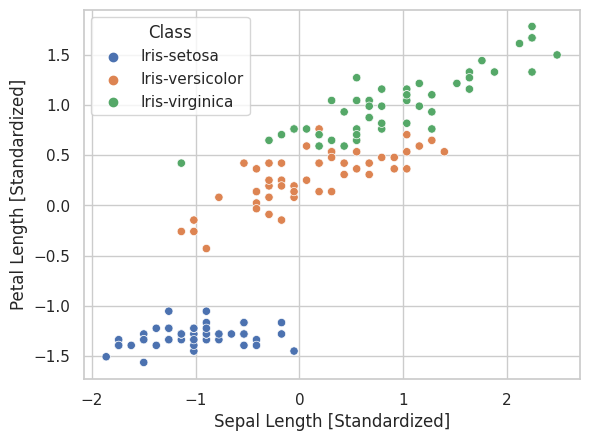

In [49]:
df = pd.read_csv(
            "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
            header=None,
            encoding="utf-8"
        )
df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length','Petal Width','Class']

for col in df.columns:
    if is_float_dtype(df[col].dtype):
        mean = df[col].mean()
        std  = df[col].std()

        df[col] = df[col]\
                    .apply(lambda x: (x - mean) / std)

        df = df.rename(columns={col: f"{col} [Standardized]"})
seaborn.set(style='whitegrid')
seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=df)

<h3 id="step2">Step 2 - The Kernel SVM Algorithm</h4>

In [50]:
class Trainable(ABC):
        
        @abstractmethod
        def train(self, X: np.ndarray, 
                        y: np.ndarray,
                        seed: Optional[int] = None
                    ):
            pass

        @abstractmethod
        def predict(self, X: np.ndarray) -> np.ndarray:
            pass 

class Kernels(ABC):
    
    @staticmethod
    def linear(a: np.ndarray, b: np.ndarray) -> np.ndarray:
          """Linear kernel implementation for KVM
          :param a: feature vector 
          :type a: np.ndarray
          :param b: feature vector
          :type b: np.ndarray
          :returns: feature embedded vector
          :rtype: np.ndarray
          """
          return np.dot(a,b)
    
    @staticmethod
    def polynomial(degree: int) -> Callable[[np.ndarray,np.ndarray], np.ndarray]:
         """Returns a polynomial kernel method of the given order
         :param degree: the degree of the polynomial
         :type a: int
         :returns: method
         :rtype: callable
         """
         return lambda a,b: (1 + np.dot(a,b))**degree
    
    @staticmethod
    def rbf(gamma: float) -> Callable[[np.ndarray,np.ndarray], np.ndarray]:
        """Returns an rbf kernel method with a given gamma
         :param degree: the degree of the polynomial
         :type a: int
         :returns: method
         :rtype: callable
        """
        return lambda a,b: np.exp(-gamma * np.sum(np.subtract(a,b)**2, axis=-1))
            
class KernelSVM(Trainable):

    def __init__(self, kernel: Callable[[np.ndarray,np.ndarray],np.ndarray],
                       reg: float = 0.01,
                       n: int = 1000,
                       eta: float = 0.1):
        """Initialize and Adaline algorithm
        :param weights: initial weights 
        :type weights: ndarray | Column vector with size features + 1
        :param n: number of training iterations
        :type n: int
        :param alpha: the learning rate
        :type alpha: float , 0 < a < 1
        """
        self.reg: float = reg
        self.n: int = n
        self.eta: float = eta
        self.kernel: Callable[[np.ndarray,np.ndarray],np.ndarray] = kernel
        self.alphas: Optional[np.ndarray] = None
        self.labels: Optional[np.ndarray] = None
        self.features: Optional[np.ndarray] = None 
        self.bias: Optional[float] = None
    
    def train(self, X: np.ndarray, 
                    y: np.ndarray):
        """Train the weights for Adaline algorithm
        :param X: ndarray of feature vectors, bias element will
        be added automatically
        :type X: ndarray
        :param y: ndarray of result vector
        :type y: ndarray
        :param seed: seed for random number generator
        :type seed: None or int
        """
        self.alphas = np.zeros(X.shape[0])
        self.labels = y.copy()
        self.features = X.copy()
        self.bias = 0.0

        for _ in range(self.n):
            
            temp = np.array([np.dot(self.alphas* y, self.kernel(X,X[idx])) + self.bias
                        for idx in range(X.shape[0])])

            deltas = np.where(y * temp <= 1, 1, 0)
                
            self.alphas = (1 - self.reg * self.eta) * self.alphas + (self.eta / X.shape[0]) * deltas
            self.bias += (self.eta / X.shape[0]) * np.dot(y, deltas)

        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions based on internal weights
        :param X: the input vector (either the full sample set, 
        or a single sample)
        :type X: np.ndarray
        :param hardpred: Hard Prediction or soft?
        :type hardpred: bool
        :returns: prediction vector
        :rtype: ndarray
        """
        k = [self.kernel(X,self.features[idx]) 
                for idx in range(self.features.shape[0])]
        
        return np.sign(np.dot(self.alphas * self.labels, k) + self.bias)
    
    def draw_decision_boundary(self,
                                X: np.ndarray,
                                r: float = 0.02,
                                fill: bool = True):
        """Draw the decision boundary
        requires matplotlib
        :param X: feature vector
        :type X: np.ndarray
        :param r: resolution of the grid
        :type r: float
        """
        #define the corner points for a rectangle that
        #encapsulates our (2d) feature plane
        x1_min , x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min , x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        #generate points on this plane 
        #that splits the plane into a grid
        xx1, xx2 = np.meshgrid(
            np.arange(x1_min, x1_max, r),
            np.arange(x2_min, x2_max, r)
        )

        #generate predictions for everypoint in this grid
        #using the trained model
        pred = self.predict(
            np.array([xx1.ravel(), xx2.ravel()]).T
        )

        pred = pred.reshape(xx1.shape)
        
        colors = ['blue','red']
            
        cmap = ListedColormap(colors)
        if fill:
            plt.contourf(xx1, xx2, pred, alpha=0.3, cmap=cmap)
        else:
            plt.contour(xx1, xx2, pred, alpha=0.3, cmap=cmap)

In [51]:
def prepare_data(df: pd.DataFrame, 
                 features: List[str],
                 class_row: str = "Class") -> (np.ndarray, np.ndarray):
    """Prepare the dataframe into input and target arrays
    :param df: pandas dataframe containing feature and target vectors
    :type df: DataFrame
    :param features: row names of features as a list
    :type features: List of strings
    :param class_row: Row name of target vector
    :type class_row: str (default = "Class")
    :returns: X , y
    :rtype: np.ndarray , np.ndarray
    """
    id_map = {name: idx
                for idx, name in enumerate(set(df[class_row]))
                }
    
    y = df[class_row]\
            .apply(lambda x: -1 if id_map[x] == 0 else 1)\
            .to_numpy()
    
    X = df[features].to_numpy()

    return X , y

<h3 id="step3">Step 3 - LINEAR-kernel SVM</h3>

Success Rate: 100.00%


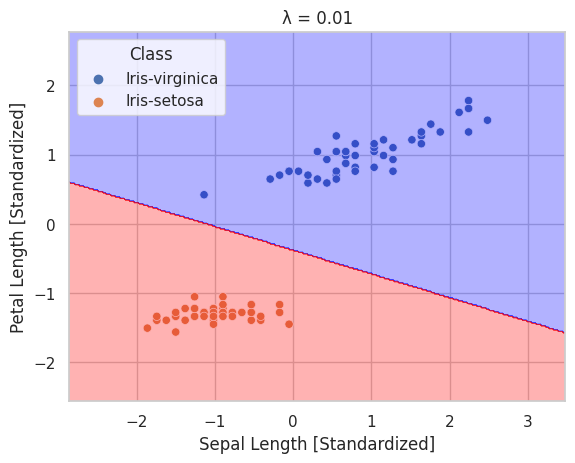

In [84]:
#use the model
features = ['Sepal Length [Standardized]','Petal Length [Standardized]']
df = df.sort_values(by='Class',ascending=False)
clean_df = df[df['Class'].isin(['Iris-virginica','Iris-setosa'])]
X , y = prepare_data(clean_df, features)

model = KernelSVM(
    Kernels.linear,
    n=100,
    reg=0.01,
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

model.draw_decision_boundary(X)
plt.title("λ = 0.01")
predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

When the regularization parameter λ is set low, the Linear SVM becomes a hard-boundary SVM where the algorithm tries
to include every training sample in the correct boundary. This results in lower seperation margins between the classes.

Notice how that one training sample of Iris-virginica is now classified as `setosa` when the regularization λ parameter is set to 5. Despite a lower success
rate for the training set, the margins are wider. The regularization parameter helps to avoid overfitting the training dataset.

Success Rate: 99.00%


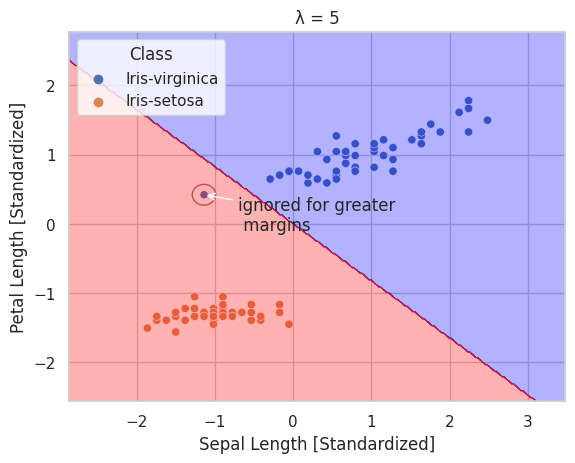

In [85]:
model = KernelSVM(
    Kernels.linear,
    n=100,
    reg=5,
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

model.draw_decision_boundary(X)
cir = plt.Circle((-1.14, 0.42), 0.15, color='r',fill=False)
splt.add_patch(cir)
splt.annotate('ignored for greater \n margins', xy=(-1.14,0.42), xytext=(-0.7,-0.1),arrowprops = dict(facecolor ='red',arrowstyle='->'))
plt.title("λ = 5")
predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

<h3 id="step4">Step 4 - Polynomial-Kernel SVM</h3>

Success Rate: 97.33%


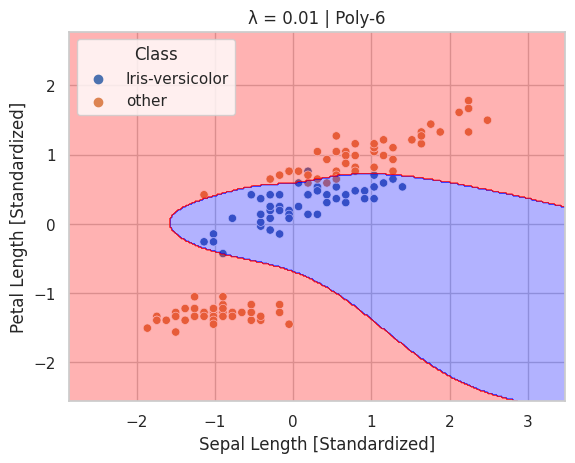

In [86]:
#use the model
features = ['Sepal Length [Standardized]','Petal Length [Standardized]']
clean_df = df.copy()
clean_df['Class'] = clean_df['Class'].apply(lambda x: "other" if x != "Iris-versicolor" else "Iris-versicolor")
clean_df = clean_df[clean_df['Class'].isin(['Iris-versicolor','Iris-virginica','other'])]
clean_df = clean_df.sort_values(by='Class',ascending=True)
X , y = prepare_data(clean_df, features)


model = KernelSVM(
    Kernels.polynomial(6),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

plt.title("λ = 0.01 | Poly-6")
model.draw_decision_boundary(X)

predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

Success Rate: 94.00%


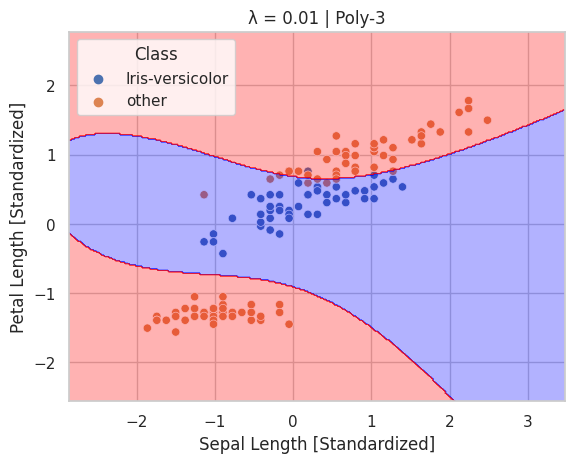

In [87]:
model = KernelSVM(
    Kernels.polynomial(3),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

plt.title("λ = 0.01 | Poly-3")
model.draw_decision_boundary(X)

predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

Polynomials of degree 5,6 seem to perform the best with ~97% success rate. Below is a pre-calculated animation of the effect of the regularization parameter on the Poly-5 kernel.

My observation is that as the regularization parameter gets larger the model is more likely to underfit. As it gets lower it is more likely to overfit.

<h4 id="step5"> Step 5 - [BONUS] RBF Kernel</h4>

Success Rate: 88.00%


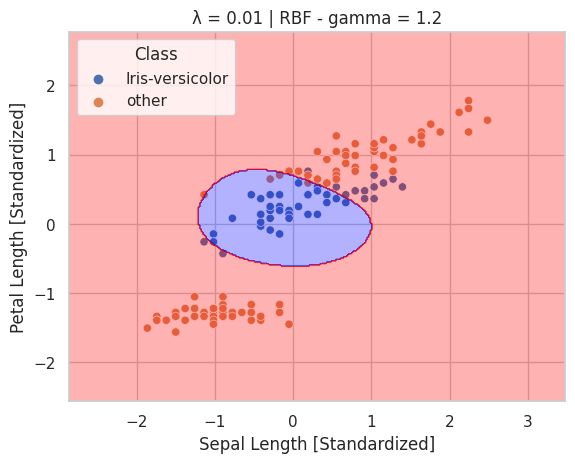

In [88]:
model = KernelSVM(
    Kernels.rbf(1.2),
    n=100,
    reg=0.01
)
model.train(X.copy(),y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=clean_df)

plt.title("λ = 0.01 | RBF - gamma = 1.2")
model.draw_decision_boundary(X)

predict = model.predict(X)
error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Success Rate: {100 - error_rate:.2f}%")

The `RBF` kernel does not perform nearly as well as the `Polynomial` kernel on this dataset based on the error-rate.

<h4 id="step6">Step 6 - [BONUS] All-Pair Multi SVM</h4>

It is Trivial to adapt the AllPairClassifier from the last assignment to use with the KernelSVM. We just need to make sure that the labels are set to {-1, 1} rather than {0, 1}.

In [93]:
class AllPairClassifier(Trainable):

    def __init__(self, model_class: Trainable,
                        **kwargs):
        """Train multiple binary classifiers 
        in an all pair scheme
        :param model_class: Model class to be used in the training
        :type model_class: Trainable
        :Keyword Arguments:
            Are passed to the model_class init function
        """
        self._model_class: Trainable = model_class
        self._model_kwargs: dict = kwargs
        self._models: Dict[tuple, Trainable] = dict()
        self._classes: int = 0

    @staticmethod
    def _count_votes(lst: list):
        """ 
        """
        d = defaultdict(lambda: 0)
        for item in lst:
            d[item] += 1
        
        return max(d, key=d.get)
        
    def train(self, X: np.ndarray, 
                    y: np.ndarray,
                    seed: Optional[int] = None):
        """
        Trains m * (m-1) / 2 models for every distinct pair
        of classes
        :param X: the array of features
        :type X: np.ndarray
        :param y: target vector
        :type y: np.ndarray
        :param seed: seed for random weight vector (passed to underlying model)
        :type seed: Optional[int]
        """
        pairs: List[tuple] = list(itertools.combinations(set(y), 2))

        for (val1, val2) in pairs:
            suby = y[(y == val1) | (y == val2)]
            suby = np.where(suby == max(suby), 1, -1)
            subX = X[(y == val1) | (y == val2)]
            model = self._model_class(**self._model_kwargs)
            model.train(subX, suby)

            self._models[(val1,val2)] = model
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions based on internal weights
        :param X: the input vector (either the full sample set, 
        or a single sample)
        :type X:
        :returns: prediction vector
        :rtype: ndarray
        """
        results = []
        for (key1, key2), model in self._models.items():
            pred = model.predict(X)
            results.append(
                np.where(pred == 1, max(key1,key2), min(key1,key2))
            )

        #aggregate the votes
        return np.array(
                [self._count_votes(result) for result in np.array(results).T]
        )
            
    def draw_decision_boundary(self,
                                X: np.ndarray,
                                r: float = 0.02):
        """Draw the decision boundary
        requires matplotlib
        :param X: feature vector
        :type X: np.ndarray
        :param r: resolution of the grid
        :type r: float
        """
        #define the corner points for a rectangle that
        #encapsulates our (2d) feature plane
        x1_min , x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min , x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        #generate points on this plane 
        #that splits the plane into a grid
        xx1, xx2 = np.meshgrid(
            np.arange(x1_min, x1_max, r),
            np.arange(x2_min, x2_max, r)
        )

        #generate predictions for everypoint in this grid
        #using the trained model
        pred = self.predict(
            np.array([xx1.ravel(), xx2.ravel()]).T
        )

        pred = pred.reshape(xx1.shape)
        
        colors = ['red','green','blue']
            
        cmap = ListedColormap(colors)
        plt.contourf(xx1, xx2, pred, alpha=0.3, cmap=cmap)

In [94]:
def prepare_data_multi(df: pd.DataFrame, 
                 features: List[str],
                 class_row: str = "Class") -> (np.ndarray, np.ndarray):
    """Prepare the dataframe into input and target arrays
    :param df: pandas dataframe containing feature and target vectors
    :type df: DataFrame
    :param features: row names of features as a list
    :type features: List of strings
    :param class_row: Row name of target vector
    :type class_row: str (default = "Class")
    :returns: X , y
    :rtype: np.ndarray , np.ndarray
    """
    id_map = {name: idx 
                for idx, name in enumerate(set(df[class_row]))
                }
    
    y = df[class_row]\
            .apply(lambda x: id_map[x])\
            .to_numpy()
    
    X = df[features].to_numpy()

    return X , y

Error Rate: 2.67%


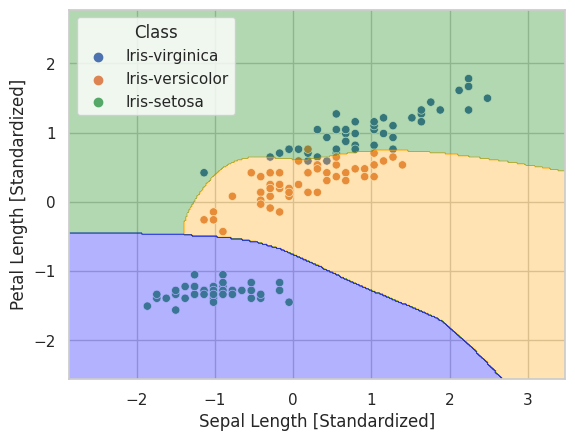

In [95]:
multi_model = AllPairClassifier(
    model_class=KernelSVM,
    n=100,
    reg=0.1,
    kernel=Kernels.polynomial(6)
)
X, y = prepare_data_multi(df, features)
multi_model.train(X, y)

splt = seaborn.scatterplot(x='Sepal Length [Standardized]',
                    y='Petal Length [Standardized]',
                    hue='Class',
                    data=df)
multi_model.draw_decision_boundary(X)
predict = multi_model.predict(X)

error_rate = 100 * (len(y) - np.equal(predict,y).sum())/len(y)
print(f"Error Rate: {error_rate:.2f}%")